# MayrUQ: Virtual Measurements of Polar Organic Reactivity

Dear user,

This interactive notebook allows you to calculate 
1. reactivity parameters for electrophiles (electrophilicity $E$) and nucleophiles (nucleophilicity $N$ and sensitivity $s_\mathrm{N}$), as well as
2. rate constants of bimolecular polar reactions, $k$, calibrated with reference to 20 °C.

The calculation of rate constants is based on the Mayr–Patz equation (MPE),

\begin{equation}
    \log k_\mathrm{MPE} = s_\mathrm{N} (N + E) \approx \log k_\mathrm{experiment}
\end{equation}

Our approach to calculating reactivity parameters and rate constants is rooted in uncertainty quantification.
It transforms the *unique* values of those quantities into value *distributions*.
This extension allows you to perform *virtual* measurements of polar organic reactivity, which are reported as expectation $\pm$ deviation (95% confidence interval), just like *physical* measurements.

Please cite the following reference when publishing results generated with this notebook, also if you post-processed them: 

J. Proppe, J. Kircher, *ChemRxiv* **2021**, https://doi.org/10.26434/chemrxiv.14102372.v1

Currently, virtual measurements can be performed for 32 electrophiles, 36 nucleophiles, and all combinations thereof (a warning is printed if the condition $-5 < \log k_\mathrm{MPE} < +8$ is violated). 
For a more comprehensive set of reactivity parameters for which uncertainty estimates are not yet available, see Mayr's Database of Reactivity Parameters: https://www.cup.lmu.de/oc/mayr/reaktionsdatenbank2/.

If you would like to provide us with feedback, report technical problems, etc., please contact me at jproppe@uni-goettingen.de.

Kind regards,

Jonny Proppe, 27 June 2021

In [1]:
# preparatory steps

import dill
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from   scipy.stats import norm

model   = dill.load(open('model2.pkl', 'rb'))
nuc_id  = np.unique(model.rxns.index.nuc[np.where(model.rxns.status == 'ok')[0]])
elec_id = np.unique(model.rxns.index.elec[np.where(model.rxns.status == 'ok')[0]])

x = []

for b in range(28, 10028):
    x.append(model.result[b].x)
    
x = np.array(x)
X = {
    'sN' : {},
    'N'  : {},
    'E'  : {}
}

for i in range(len(nuc_id)):
    X['N'][nuc_id[i]]  = x[:,35+i]
    if nuc_id[i] < model.nuc.anchor:
        X['sN'][nuc_id[i]] = x[:,i]
    elif nuc_id[i] > model.nuc.anchor:
        X['sN'][nuc_id[i]] = x[:,i-1]
    else:
        X['sN'][model.nuc.anchor] = np.ones(10000)
        
for j in range(len(elec_id)):
    if elec_id[j] < model.elec.anchor:
        X['E'][elec_id[j]] = x[:,71+j]
    elif elec_id[j] > model.elec.anchor:
        X['E'][elec_id[j]] = x[:,71+j-1]
    else:
        X['E'][model.elec.anchor] = np.zeros(10000)

# UQ for Electrophiles

Run the following cell and enter a valid electrophile ID (32 in total, see paper).
The title of the plot will show you the mean value of the bootstrapped electrophilicity parameter $E$ (the actual version 2.0 reactivity parameter) as well as the corresponding symmetric 95% confidence interval (= 1.96 times the standard deviation of $E$).
The empirical distribution obtained from bootstrapping is shown as blue histogram.
A Gaussian fit to the empirical distribution is shown as black dashed curve.

Which electrophile would you like to query? 25


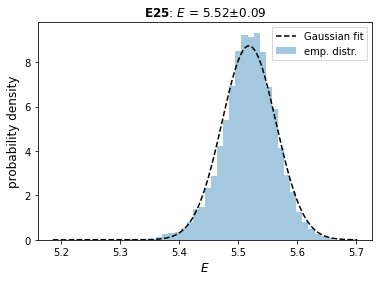

In [2]:
idx = int(input('Which electrophile would you like to query? '))

if not idx in elec_id:
    raise Exception('Sorry, but we cannot find data for the electrophile queried.')

E = X['E'][idx]
    
E_mu  = np.mean(E)
E_u95 = np.quantile(E, .975)
E_l95 = np.quantile(E, .025)
E_q95 = 1.96 * np.std(E, ddof=1)

E_pdf_x = np.linspace(np.min(E), np.max(E), 1000)
E_pdf_y = norm.pdf(E_pdf_x, np.mean(E), np.std(E))
    
sns.distplot(E, kde=False, norm_hist=True, label='emp. distr.')
plt.title('$\mathbf{E' + str(idx) + '}$: $E$ = ' + str(f"{E_mu:.2f}") + '$\pm$' + str(f"{E_q95:.2f}"))
plt.plot(E_pdf_x, E_pdf_y, 'k--', label='Gaussian fit')
plt.xlabel('$E$', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend()
plt.show()

# UQ for Nucleophiles

Run the following cell and enter a valid nucleophile ID (36 in total, see paper).
The remaining procedure is equivalent to that for electrophiles (see above).
A third diagram shows $s_\mathrm{N}$ versus $N$.
Its title informs about Pearson's correlation coefficient, $r$, between $s_\mathrm{N}$ versus $N$.

Which nucleophile would you like to query? 8


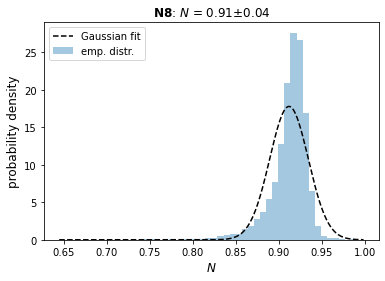

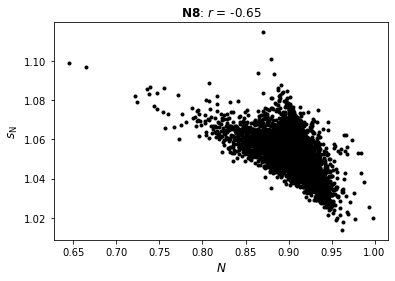

In [3]:
idx = int(input('Which nucleophile would you like to query? '))

if not idx in nuc_id:
    raise Exception('Sorry, but we cannot find data for the nucleophile queried.')

sN = X['sN'][idx]
N  = X['N'][idx]
    
sN_mu  = np.mean(sN)
sN_u95 = np.quantile(sN, .975)
sN_l95 = np.quantile(sN, .025)
sN_q95 = 1.96 * np.std(sN, ddof=1)

sN_pdf_x = np.linspace(np.min(sN), np.max(sN), 1000)
sN_pdf_y = norm.pdf(sN_pdf_x, np.mean(sN), np.std(sN))
    
sns.distplot(sN, kde=False, norm_hist=True, label='emp. distr.')
plt.title('$\mathbf{N' + str(idx) + '}$: $s_\mathrm{N}$ = ' + str(f"{sN_mu:.2f}") + '$\pm$' + str(f"{sN_q95:.2f}"))
plt.plot(sN_pdf_x, sN_pdf_y, 'k--', label='Gaussian fit')
plt.xlabel('$s_\mathrm{N}$', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend()
plt.show()
    
N_mu  = np.mean(N)
N_u95 = np.quantile(N, .975)
N_l95 = np.quantile(N, .025)
N_q95 = 1.96 * np.std(N, ddof=1)

N_pdf_x = np.linspace(np.min(N), np.max(N), 1000)
N_pdf_y = norm.pdf(N_pdf_x, np.mean(N), np.std(N))
    
sns.distplot(N, kde=False, norm_hist=True, label='emp. distr.')
plt.title('$\mathbf{N' + str(idx) + '}$: $N$ = ' + str(f"{N_mu:.2f}") + '$\pm$' + str(f"{N_q95:.2f}"))
plt.plot(N_pdf_x, N_pdf_y, 'k--', label='Gaussian fit')
plt.xlabel('$N$', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend()
plt.show()

r = np.corrcoef(sN, N)[0,1]

plt.plot(N, sN, 'k.')
plt.xlabel('$N$', fontsize=12)
plt.ylabel('$s_\mathrm{N}$', fontsize=12)
plt.title('$\mathbf{N' + str(idx) + '}$: $r$ = ' + str(f"{r:.2f}"))
plt.show()

# UQ for Reactions

Run the following cell and enter a valid nucleophile ID as well as a valid electrophile ID.
The title of the first plot shows (i) the mean of the empirical $\log k_\mathrm{MPE}$ distribution obtained through uncertainty propagation (**UP**) of the bootstrapped distributions for $s_\mathrm{N}$, $N$, and $E$, as well as (ii) the corresponding symmetric 95% confidence interval (= 1.96 times the standard deviation of $E$).
The same plot also shows the value of $\log k_\mathrm{MPE}$ that would have been obtained by applying the Mayr$-$Patz equation (Eq. 1 in the paper) to the mean values of the bootstrapped parameter distributions ($\overline{s_\mathrm{N}}$, $\overline{N}$, and $\overline{E}$):

$\overline{\log k_\mathrm{MPE}} = \overline{s_\mathrm{N}} (\overline{N} + \overline{E})$

The subsequent diagrams show $s_\mathrm{N}$ versus $N$, $s_\mathrm{N}$ versus $E$, and $N$ versus $E$.
Their titles informs about Pearson's correlation coefficient, $r$, between the three pairs of random variables.

Which nucleophile would you like to query? 8
Which electrophile would you like to query? 25


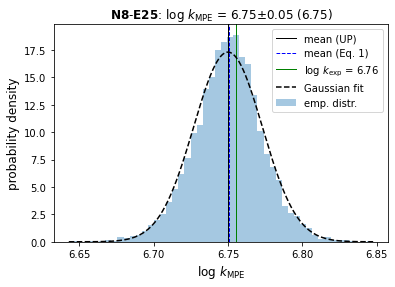

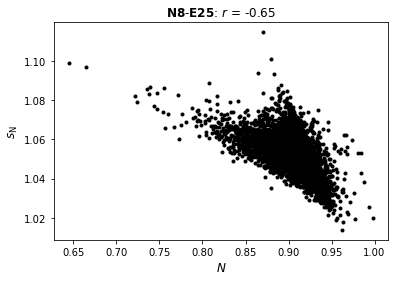

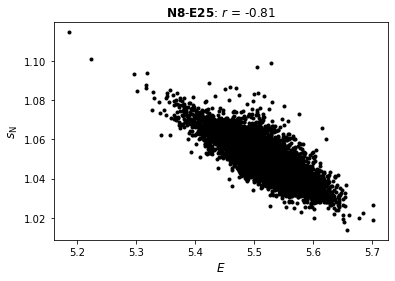

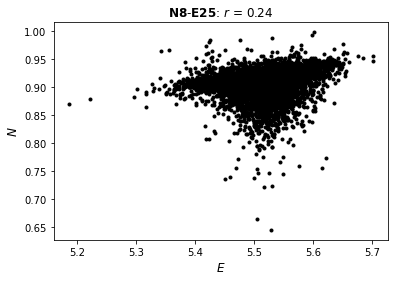

In [4]:
idx_nuc  = int(input('Which nucleophile would you like to query? '))
idx_elec = int(input('Which electrophile would you like to query? '))

if not idx in nuc_id:
    raise Exception('Sorry, but we cannot find data for the nucleophile queried.')

if not idx in elec_id:
    raise Exception('Sorry, but we cannot find data for the electrophile queried.')

nuc_where  = np.where(model.rxns.index.nuc == idx_nuc)[0]
elec_where = np.where(model.rxns.index.elec == idx_elec)[0]
rxn_where  = np.intersect1d(nuc_where, elec_where)
    
E  = X['E'][idx_elec]
sN = X['sN'][idx_nuc]
N  = X['N'][idx_nuc]

logk = sN * (N + E)

logk_mu1 = np.mean(logk)
logk_mu2 = np.mean(sN) * (np.mean(N) + np.mean(E))
logk_u95 = np.quantile(logk, .975)
logk_l95 = np.quantile(logk, .025)
logk_q95 = 1.96 * np.std(logk, ddof=1)

logk_pdf_x = np.linspace(np.min(logk), np.max(logk), 1000)
logk_pdf_y = norm.pdf(logk_pdf_x, np.mean(logk), np.std(logk))

if logk_mu1 < -5.:
    print('\nWARNING: The queried reaction may be too slow to be suitable for experimental monitoring.')
                
if logk_mu1 > +8.:
    print('\nWARNING: The rate of the queried reaction appears to be near the diffusion limit. Do not trust or use the following results as they are expected to be unreliable.')

sns.distplot(logk, kde=False, norm_hist=True, label='emp. distr.')
plt.title('$\mathbf{N' + str(idx_nuc) + '}$-$\mathbf{E' + str(idx_elec) + '}$: $\log$ $k_\mathrm{MPE}$ = ' + str(f"{logk_mu1:.2f}") + '$\pm$' + str(f"{logk_q95:.2f}") + ' (' + str(f"{logk_mu2:.2f}") +')')
plt.axvline(logk_mu1, color='k', linewidth=1., label='mean (UP)')
plt.axvline(logk_mu2, color='b', linewidth=1., label='mean (Eq. 1)', linestyle='--')

if len(rxn_where) == 1:
    logk_exp = np.log10(model.rxns.k_exp[rxn_where]).item()
    plt.axvline(logk_exp, color='g', linewidth=1., label='$\log$ $k_\mathrm{exp}$ = ' + str(f"{logk_exp:.2f}"))

plt.plot(logk_pdf_x, logk_pdf_y, 'k--', label='Gaussian fit')
plt.xlabel('$\log$ $k_\mathrm{MPE}$', fontsize=12)
plt.ylabel('probability density', fontsize=12)
plt.legend()
plt.show()

r_sN_N = np.corrcoef(sN, N)[0,1]
r_sN_E = np.corrcoef(sN, E)[0,1]
r_E_N  = np.corrcoef(E, N)[0,1]

plt.plot(N, sN, 'k.')
plt.xlabel('$N$', fontsize=12)
plt.ylabel('$s_\mathrm{N}$', fontsize=12)
plt.title('$\mathbf{N' + str(idx_nuc) + '}$-$\mathbf{E' + str(idx_elec) + '}$: $r$ = ' + str(f"{r_sN_N:.2f}"))
plt.show()

plt.plot(E, sN, 'k.')
plt.xlabel('$E$', fontsize=12)
plt.ylabel('$s_\mathrm{N}$', fontsize=12)
plt.title('$\mathbf{N' + str(idx_nuc) + '}$-$\mathbf{E' + str(idx_elec) + '}$: $r$ = ' + str(f"{r_sN_E:.2f}"))
plt.show()

plt.plot(E, N, 'k.')
plt.xlabel('$E$', fontsize=12)
plt.ylabel('$N$', fontsize=12)
plt.title('$\mathbf{N' + str(idx_nuc) + '}$-$\mathbf{E' + str(idx_elec) + '}$: $r$ = ' + str(f"{r_E_N:.2f}"))
plt.show()